In [22]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from matplotlib import gridspec
%matplotlib inline
from pathlib import Path
import os
os.chdir(Path(os.getcwd()).absolute().parent)
from bayes_opt import BayesianOptimization
import bayesian_optimizer
import numpy as np
import matplotlib.pyplot as plt

In [23]:
def posterior(gp, x):
    return gp.predict(x, return_std=True)

def plot_gp(gp, x, y, util):
    
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Gaussian Process and Utility Function After {} Steps'.format(len(bo.X)), fontdict={'size':30})
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    mu, sigma = posterior(gp, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(gp.X_train_.flatten(), gp.y_train_, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})

    utility = util.utility(x, gp, gp.y_train_.max()) ##0???
        
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 10))
    acq.set_ylim((0, np.max(utility) * 1.2))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    
    
def my_plot_gp(gp_y, gp_c, x, y, c, util_ei, util_cei, constraint_upper):
    
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Gaussian Process and Utility Function After {} Steps'.format(len(gp_y.X_train_)), fontdict={'size':30})
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
#     posterior 1
    mu_y, sigma_y = posterior(gp_y, x)
    axis.plot(x, y, linewidth=3, label='Target', color='lightblue')
    axis.plot(gp_y.X_train_.flatten(), gp_y.y_train_, 'D', markersize=8, label=u'Target Observations', color='r')
    axis.plot(x, mu_y, '--', color='lightblue', label='Target Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu_y - 1.9600 * sigma_y, (mu_y + 1.9600 * sigma_y)[::-1]]),
        alpha=.3, fc='c', ec='None', label='95% confidence interval', color='lightblue')
    
    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    

    # posterior 2
    mu_c, sigma_c = posterior(gp_c, x)
    axis.plot(x, c, linewidth=3, label='Target', color='y')
    axis.plot(gp_c.X_train_.flatten(), gp_c.y_train_, 'D', markersize=8, label=u'Constraint Observations', color='r')
    axis.plot(x, mu_c, '--', color='y', label='Constraint Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu_c - 1.9600 * sigma_c, (mu_c + 1.9600 * sigma_c)[::-1]]),
        alpha=.3, fc='c', ec='None', label='95% confidence interval', color='y')
    
    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
#     axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    # Constraint
    axis.plot(x, [constraint_upper]*len(x), label='constraint_upper', color='k')
    
    utility = util_ei.utility(x) ##0???
    utility_cei = util_cei.utility(x) ##0???
        
    acq.plot(x, utility, label='Utility Function EI', color='r', alpha=.3)
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    
    acq.plot(x, utility_cei, label='Utility Function CEI', color='g', alpha=.3)
    acq.plot(x[np.argmax(utility_cei)], np.max(utility_cei), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 10))
    acq.set_ylim((0, np.max(np.hstack((utility, utility_cei))*1.2)))
#     acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

### Target function

In [24]:
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

def constraint_func(x):
    return -0.14*x + 1.5

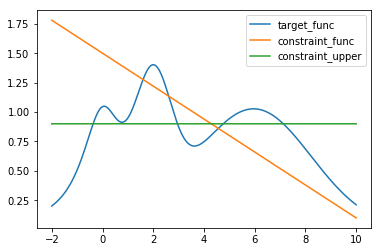

In [25]:
x = np.linspace(-2, 10, 10000).reshape(-1, 1)
y = target(x)

c = constraint_func(x)
constraint_upper = 0.9

plt.plot(x, y, label='target_func')
plt.plot(x, c, label='constraint_func')
plt.plot(x, [constraint_upper]*len(x), label='constraint_upper')
plt.legend()

In [26]:
X_train = np.array([[0], [4], [8]])
Y_train = np.array(list(map(target, list(X_train.reshape(1,-1).squeeze()))))
C_train = constraint_func(X_train.reshape(1,-1).squeeze())

xi =1e-4
acq = 'ei'
n_iter=8
SEED = 6

## Original Implementation

In [27]:
gp_params = {"alpha": 1e-5, "n_restarts_optimizer": 25, "kernel": Matern(nu=2.5), "random_state": SEED}
bo = BayesianOptimization(target, {'x': (-2, 10)})

In [28]:
bo.explore({'x': list(X_train.reshape(1,-1).squeeze())})
bo.maximize(init_points=0, n_iter=n_iter, acq=acq, xi=xi,**gp_params)

Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |    1.04564 |    0.0000 | 
    2 | 00m00s |    0.74746 |    4.0000 | 
    3 | 00m00s |    0.68570 |    8.0000 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    4 | 00m01s |    0.20166 |   -2.0000 | 
    5 | 00m01s |    1.11985 |    1.3421 | 
    6 | 00m01s |    0.21180 |   10.0000 | 
    7 | 00m01s |    0.91559 |    0.8306 | 
    8 | 00m01s |    1.32550 |    2.3037 | 
    9 | 00m01s |    1.02148 |    6.1976 | 
   10 | 00m01s |    1.40059 |    2.0397 | 
   11 | 00m00s |    0.98249 |    5.2669 | 


## Plot

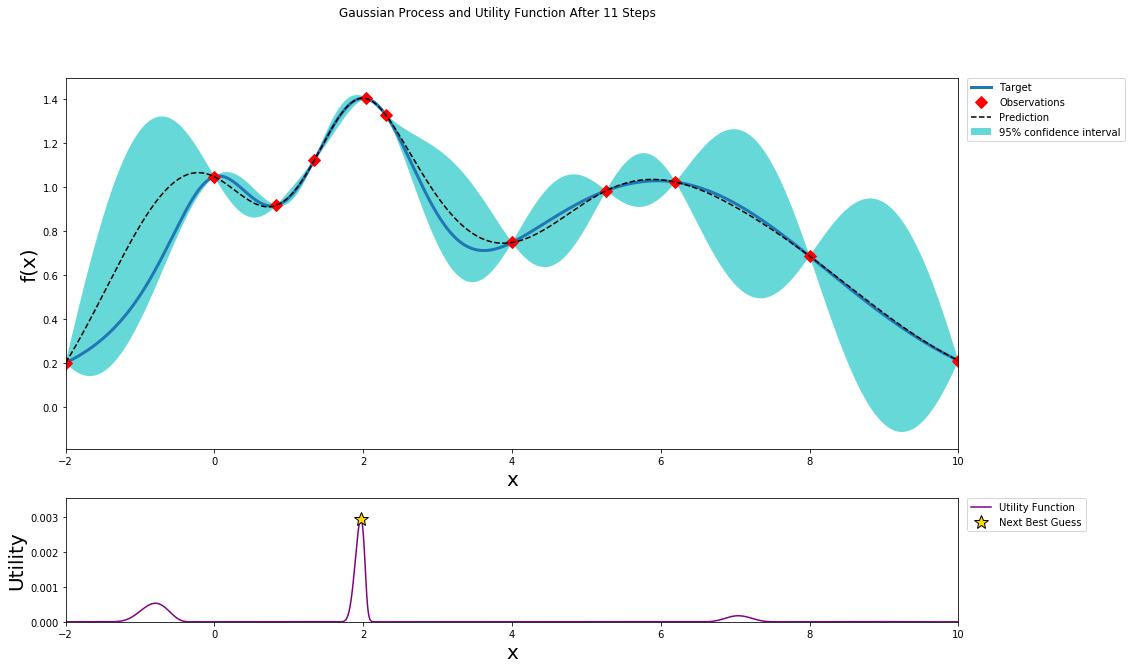

In [29]:
plot_gp(bo.gp, x, y, bo.util)

## Our implementation EI

In [30]:
candidates = []
X_train_ = X_train
Y_train_ = Y_train
for i in range(n_iter):
    candidate = bayesian_optimizer.get_candidate(X_train_, Y_train_, [(-2, 10)], acq=acq, xi=xi, **gp_params)
    X_train_ = np.vstack((X_train_, np.array([candidate])))
    Y_train_ = np.hstack((Y_train_, target(candidate)))
    candidates.append(candidate[0])

print(f"candidates \n{candidates}")
print(f"targets:\n{Y_train_}")

candidates 
[-2.0, 1.3420588712212431, 10.0, 0.83057823717961321, 2.3037020480383945, 6.1975849756092556, 2.0396844857602647, 5.2668931249734579]
targets:
[ 1.04563936  0.74745921  0.68570466  0.20166167  1.11985244  0.21179751
  0.91558958  1.32550242  1.02147788  1.40058934  0.98249183]


## Plot

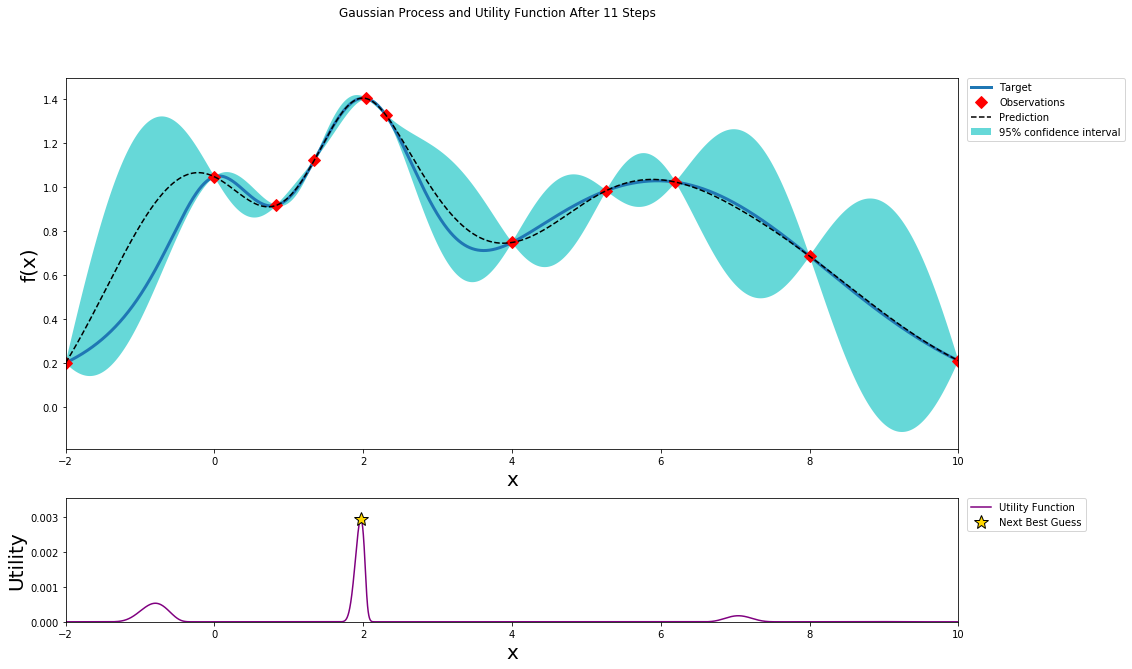

In [31]:
candidates = []
X_train_ = X_train
Y_train_ = Y_train
for i in range(n_iter):
    candidate = bayesian_optimizer.get_candidate(X_train_, Y_train_, [(-2, 10)], acq='ei', xi=xi, **gp_params)
    X_train_ = np.vstack((X_train_, np.array([candidate])))
    Y_train_ = np.hstack((Y_train_, target(candidate)))
    candidates.append(candidate[0])
    
gp = GaussianProcessRegressor()
gp.set_params(**gp_params)
gp.fit(X_train_, Y_train_)

util = bayesian_optimizer.UtilityFunction(gp_objective=gp, kind='ei', xi=xi)
plot_gp(gp, x, y, util)

## Our implementation CEI

In [32]:
candidates = []
X_train_ = X_train
Y_train_ = Y_train
C_train_ = C_train
for i in range(n_iter):
    candidate = bayesian_optimizer.get_candidate(X_train_, Y_train_, [(-2, 10)], acq='cei', xi=xi,
                                                constraint_arr=C_train_, constraint_upper=constraint_upper, **gp_params)
    X_train_ = np.vstack((X_train_, np.array([candidate])))
    Y_train_ = np.hstack((Y_train_, target(candidate)))
    C_train_ = np.hstack((C_train_, constraint_func(candidate)))
    candidates.append(candidate[0])

print('candidates:')
print(candidates)
print('targets_function:')
print(Y_train_)
print('constraint_function:')
print(C_train_)

candidates:
[9.9999931062741556, 6.0226151269090593, 6.4717076562583591, 5.5260082817615217, 5.9350168766659799, 5.9386408953794376, 5.0492493717975853, 6.0946041913411815]
targets_function:
[ 1.04563936  0.74745921  0.68570466  0.21179864  1.02677882  1.00131418
  1.00949669  1.02718368  1.02719669  0.95140708  1.02532176]
constraint_function:
[ 1.5         0.94        0.38        0.10000097  0.65683388  0.59396093
  0.72635884  0.66909764  0.66859027  0.79310509  0.64675541]


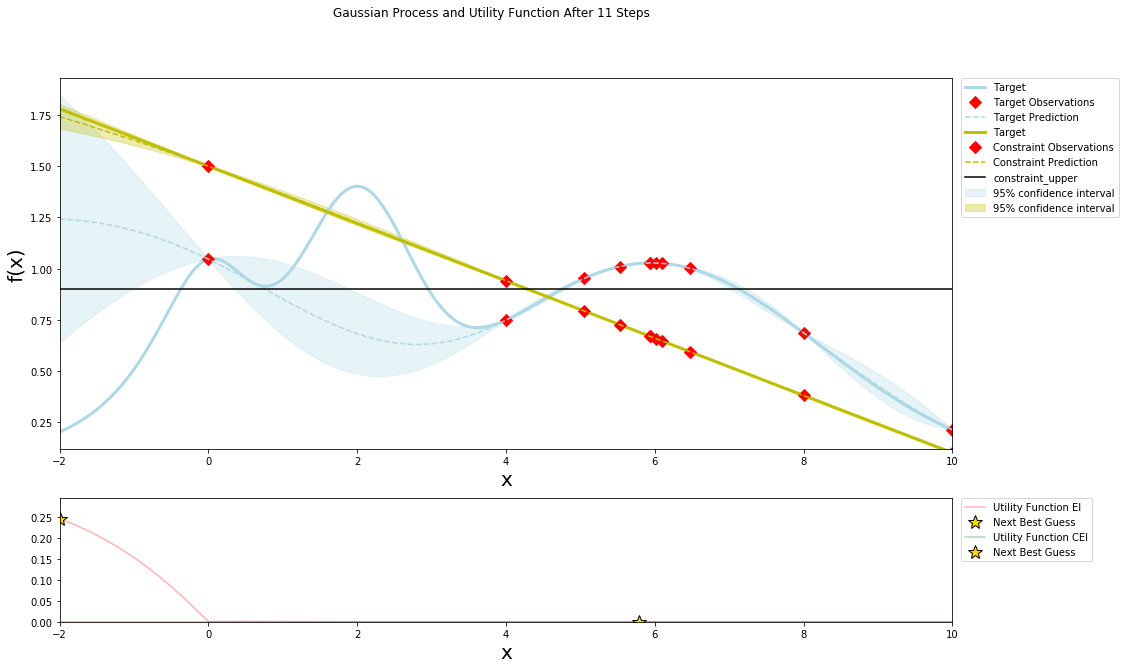

In [33]:
gp = GaussianProcessRegressor()
gp.set_params(**gp_params)
gp.fit(X_train_, Y_train_)


gp2 = GaussianProcessRegressor()
gp2.set_params(**gp_params)
gp2.fit(X_train_, C_train_)

util_ei = bayesian_optimizer.UtilityFunction(gp_objective=gp, kind='ei', xi=xi)
util_cei = bayesian_optimizer.UtilityFunction(gp_objective=gp, gp_constraint=gp2, 
                                          constraint_upper=constraint_upper, kind='cei', xi=xi)

my_plot_gp(gp, gp2, x, y, c, util_ei, util_cei, constraint_upper)

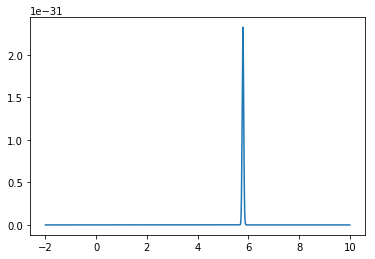

In [34]:
constraint_upper
plt.plot(x, util_cei.utility(x))